# Week 9 - Multivariate Analysis, part 2

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:
Draw heatmaps.

Draw bubble plots.

Perform Principal Component Analysis to find out the directions in which the data varies.  Can you represent the data using only its projection onto its first principal component, using the methods described in Week 8?  How much of the variance would this capture?

Try performing linear regression analysis using different sets of features.  Which features seem most likely to be useful to predict other features?

Conclusions:
Explain what conclusions you would draw from this analysis: are the data what you expect? Are the data likely to be usable? If the data are not useable, find some new data!

Do you see any outliers? (Data points that are far from the rest of the data).

Does the Principal Component Analysis suggest a way to represent the data using fewer dimensions than usual - using its first one or two principal component scores, perhaps?

Try using your correlation information from previous weeks to help choose features for linear regression.

In [47]:
import os
import zipfile
from tqdm import tqdm
import itertools
import scipy.stats as ss
import matplotlib.pyplot as plt

In [48]:
#comment out if you don't have cudf installed
import pandas as pd

In [49]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [50]:
play_df = pd.read_csv('datasets/nfl-playing-surface-analytics/PlayList.csv')
player_df = pd.read_csv('datasets/nfl-playing-surface-analytics/PlayerTrackData.csv')
injury_df = pd.read_csv('datasets/nfl-playing-surface-analytics/InjuryRecord.csv')

In [51]:
game_df = play_df[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']]
game_df = game_df.drop_duplicates()
game_df = game_df.reset_index(drop = True)
game_df

,GameID,StadiumType,FieldType,Weather,Temperature
0,26624-1,Outdoor,Synthetic,Clear and warm,63
1,26624-2,Indoors,Synthetic,Mostly Cloudy,85
2,26624-3,Outdoor,Synthetic,Sunny,84
3,26624-4,Outdoor,Synthetic,Sunny,61
4,26624-5,Outdoor,Natural,Clear,76
...,...,...,...,...,...
5707,47888-9,Outdoor,Synthetic,Cloudy,53
5708,47888-10,Outdoor,Natural,Mostly Cloudy,82
5709,47888-11,Outdoors,Natural,Cloudy,42
5710,47888-12,Outdoor,Synthetic,Clear and cold,40


In [52]:
# Helper function to add value labels on bars
def add_value_labels(ax, spacing=5, decimals=0):
    """
    Add value labels to the end of each bar in a bar chart.

    Args:
        ax (matplotlib.axes.Axes): The axis object containing the bars.
        spacing (int): Distance between the labels and bars.
        decimals (int): Number of decimal places to format the labels.
    """
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'

        format_str = f"{{:.{decimals}f}}"
        label = format_str.format(y_value)

        ax.annotate(
            label,
            (x_value, y_value),
            xytext=(0, space),
            textcoords="offset points",
            ha='center',
            va=va
        )

# Main visualization function
def visualize_game_features(game_df, rotation=90, add_labels=False, figsize=(10, 10)):
    """
    Visualize basic game-level features: StadiumType, FieldType, Weather, Temperature.
    
    Args:
        game_df (DataFrame): Input dataframe with game features.
        rotation (int): Rotation angle for x-axis labels.
        add_labels (bool): Whether to add bar value labels.
        figsize (tuple): Size of the overall figure.
    """
    # Create figure and define layout
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(4, 3, hspace=0.4, wspace=0.3)

    # Create individual axes
    stadium_ax = fig.add_subplot(grid[0, :2])
    fieldtype_ax = fig.add_subplot(grid[0, 2])
    weather_ax = fig.add_subplot(grid[1, 0:])
    temperature_ax = fig.add_subplot(grid[2, 0:])
    temperature_box_ax = fig.add_subplot(grid[3, 0:])

    # --- Stadium Type Bar Chart ---
    stadium_keys = game_df.StadiumType.value_counts().keys()
    stadium_vals = game_df.StadiumType.value_counts().values

    stadium_ax.bar(stadium_keys, stadium_vals, color='#00c2c7')
    stadium_ax.set_title('Stadium Type')
    stadium_ax.set_xticks(range(len(stadium_keys)))
    stadium_ax.set_xticklabels(stadium_keys, rotation=rotation)

    if add_labels:
        add_value_labels(stadium_ax, spacing=5)

    # --- Field Type Bar Chart ---
    fieldtype_keys = game_df.FieldType.value_counts().keys()
    fieldtype_vals = game_df.FieldType.value_counts().values

    fieldtype_ax.bar(fieldtype_keys, fieldtype_vals, color=['#00c2c7', '#ff9e15'])
    fieldtype_ax.set_title('Field Type')
    fieldtype_ax.set_xticks(range(len(fieldtype_keys)))
    fieldtype_ax.set_xticklabels(fieldtype_keys, rotation=0)

    if add_labels:
        add_value_labels(fieldtype_ax, spacing=5)

    # --- Weather Bar Chart ---
    weather_keys = game_df.Weather.value_counts().keys()
    weather_vals = game_df.Weather.value_counts().values

    weather_ax.bar(weather_keys, weather_vals, color='#00c2c7')
    weather_ax.set_title('Weather')
    weather_ax.set_xticks(range(len(weather_keys)))
    weather_ax.set_xticklabels(weather_keys, rotation=rotation)

    if add_labels:
        add_value_labels(weather_ax, spacing=5)

    # --- Temperature Histogram ---
    temp_vals = game_df.Temperature.dropna().astype(int).values

    temperature_ax.hist(temp_vals, bins=30, range=(0, 90), color='#00c2c7', edgecolor='black')
    temperature_ax.set_xlim(0, 110)
    temperature_ax.set_xticks(range(0, 110, 10))
    temperature_ax.set_xticklabels(range(0, 110, 10))
    temperature_ax.set_title('Temperature (Histogram)')

    # --- Temperature Boxplot ---
    temperature_box_ax.boxplot(temp_vals, vert=False)
    temperature_box_ax.set_xlim(0, 110)
    temperature_box_ax.set_xticks(range(0, 110, 10))
    temperature_box_ax.set_xticklabels(range(0, 110, 10))
    temperature_box_ax.set_yticks([1])
    temperature_box_ax.set_yticklabels(['Temperature'])
    temperature_box_ax.set_title('Temperature (Boxplot)')

    # --- Overall Title ---
    plt.suptitle('Game-Level Feature Exploration', fontsize=16)
    plt.show()


In [53]:
import numpy as np
import re

# --- Helper function to clean Weather descriptions ---
def clean_weather(row):
    """
    Map messy weather descriptions into consistent categories: 
    'Clear', 'Cloudy', 'Rain', 'Snow', 'Indoor', or NaN.
    
    Args:
        row (Series): Row from the dataframe with a 'Weather' column.
        
    Returns:
        str or np.nan: Cleaned weather category.
    """
    cloudy_conditions = [
        'Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
        'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
        'Mostly cloudy', 'Rain Chance 40%', ' Partly cloudy', 'Party Cloudy',
        'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain',
        'Mostly Coudy', '10% Chance of Rain', 'Cloudy, chance of rain', 
        '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"', 'cloudy', 
        'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
        'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Cloudy and cold', 'Cloudy and Cool', 'Partly cloudy'
    ]

    clear_conditions = [
        'Clear, Windy', 'Clear to Cloudy', 'Clear, highs to upper 80s', 'Clear and clear',
        'Partly sunny', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny',
        'Clear Skies', 'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s',
        'Sun & clouds', 'Mostly sunny', 'Sunny, Windy', 'Mostly Sunny Skies',
        'Clear and Sunny', 'Clear and sunny', 'Clear to Partly Cloudy', 'Clear Skies',
        'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold',
        'Sunny and warm', 'Sunny and clear'
    ]

    rainy_conditions = [
        'Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 
        'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain'
    ]

    snow_conditions = ['Heavy lake effect snow']

    indoor_conditions = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']

    # Map the raw Weather values to categories
    if row.Weather in cloudy_conditions:
        return 'Cloudy'
    if row.Weather in indoor_conditions:
        return 'Indoor'
    if row.Weather in clear_conditions:
        return 'Clear'
    if row.Weather in rainy_conditions:
        return 'Rain'
    if row.Weather in snow_conditions:
        return 'Snow'
    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan

    # If not recognized, return the original
    return row.Weather

# --- Helper function to clean StadiumType descriptions ---
def clean_stadiumtype(row):
    """
    Clean specific StadiumType anomalies by setting them to NaN.
    
    Args:
        row (Series): Row from the dataframe with a 'StadiumType' column.
        
    Returns:
        str or np.nan: Cleaned stadium type.
    """
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType

# --- Main function to clean the dataframe ---
def clean_play_df(play_df):
    """
    Clean 'StadiumType' and 'Weather' fields of a play-level dataframe.
    
    Args:
        play_df (DataFrame): Raw input play dataframe.
        
    Returns:
        DataFrame: Cleaned play dataframe.
    """
    play_df_cleaned = play_df.copy()

    # --- Clean StadiumType ---
    # Standardize common StadiumType misspellings or formats using regex
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(
        r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor', regex=True
    )
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(
        r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor', regex=True
    )
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(
        r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome', regex=True
    )
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(
        r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 
        'Retractable Roof', regex=True
    )
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(
        'Open', 'Outdoor', regex=False
    )

    # Apply StadiumType anomaly cleaning
    play_df_cleaned['StadiumType'] = play_df_cleaned.apply(clean_stadiumtype, axis=1)

    # --- Clean Weather ---
    play_df_cleaned['Weather'] = play_df_cleaned.apply(clean_weather, axis=1)

    return play_df_cleaned


In [54]:
play_df_cleaned = clean_play_df(play_df)
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']]
game_df_cleaned = game_df_cleaned.drop_duplicates()
game_df_cleaned = game_df_cleaned.reset_index(drop = True)
game_df_cleaned

,GameID,StadiumType,FieldType,Weather,Temperature
0,26624-1,Outdoor,Synthetic,Clear,63
1,26624-2,Indoor,Synthetic,Cloudy,85
2,26624-3,Outdoor,Synthetic,Clear,84
3,26624-4,Outdoor,Synthetic,Clear,61
4,26624-5,Outdoor,Natural,Clear,76
...,...,...,...,...,...
5707,47888-9,Outdoor,Synthetic,Cloudy,53
5708,47888-10,Outdoor,Natural,Cloudy,82
5709,47888-11,Outdoor,Natural,Cloudy,42
5710,47888-12,Outdoor,Synthetic,Clear,40


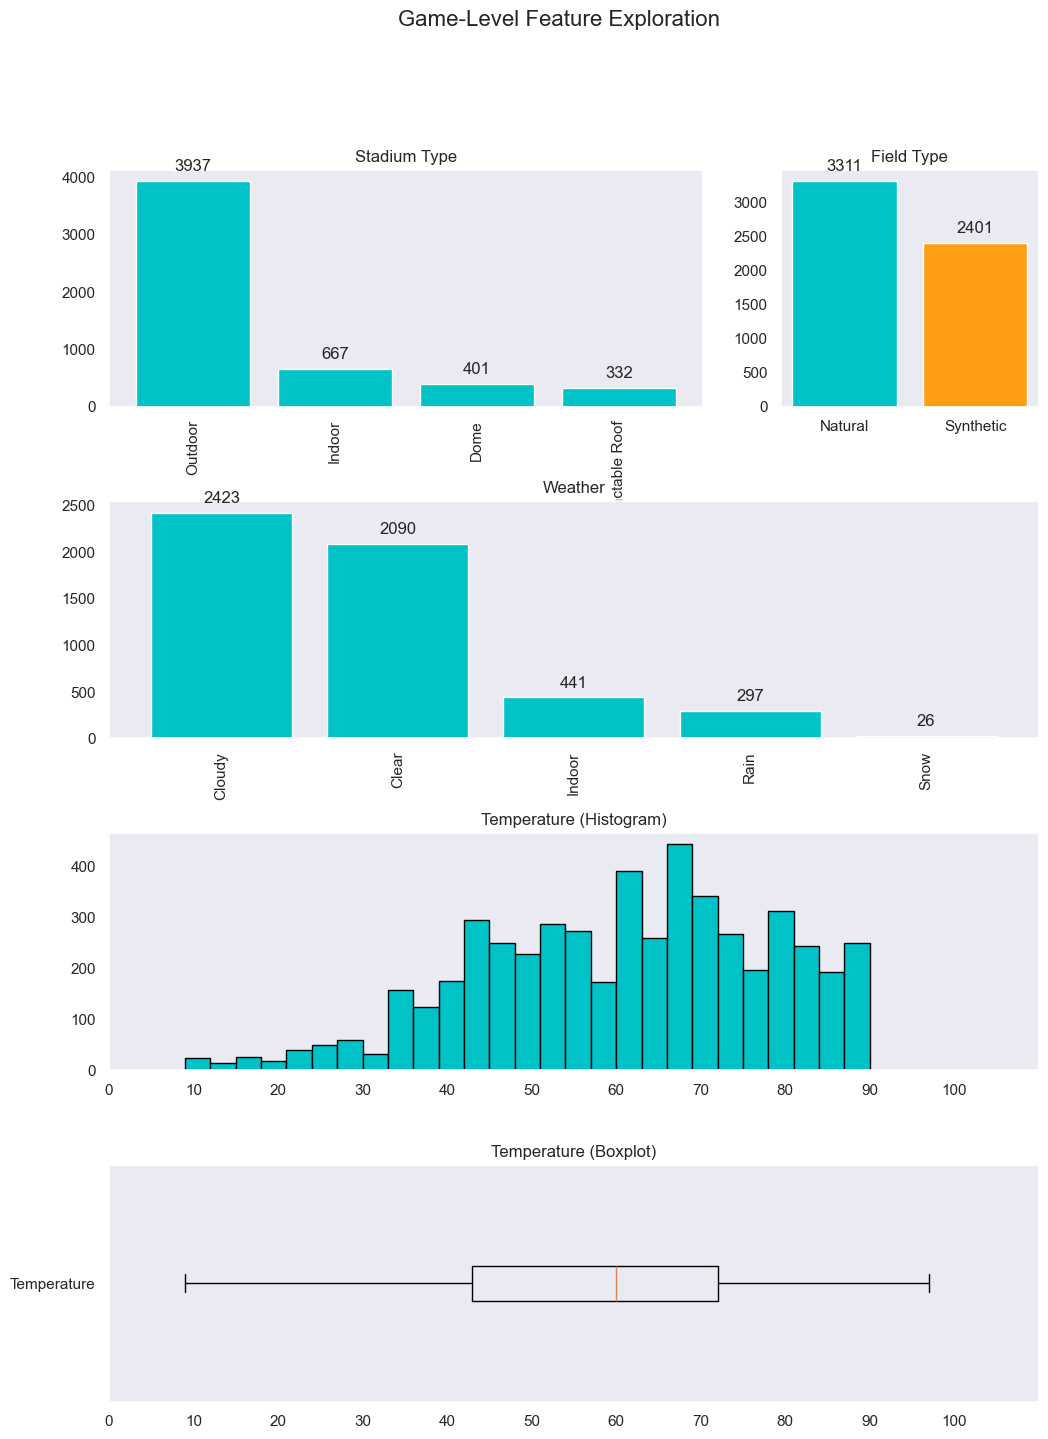

In [55]:
visualize_game_features(game_df_cleaned, rotation=90, add_labels=True, figsize=(12, 16))

### Draw heatmaps
We'll Take a look at the most visited areas of the field this week, trying to get some more info about player movement

In [56]:
player_df

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09
...,...,...,...,...,...,...,...,...,...
76366743,47888-13-55,35.8,NaN,74.97,11.50,195.95,0.13,142.95,1.34
76366744,47888-13-55,35.9,NaN,74.94,11.37,195.01,0.13,142.01,1.33
76366745,47888-13-55,36.0,NaN,74.90,11.24,193.99,0.13,143.36,1.33
76366746,47888-13-55,36.1,NaN,74.87,11.11,194.47,0.13,144.87,1.33


In [57]:
def visualize_field_heatmap(player_df, xbins=13, ybins=6, annotate=False):
    """
    Visualize a heatmap showing the most visited areas of the football field.

    Args:
        player_df (DataFrame): DataFrame containing 'x' and 'y' coordinates of player positions.
        xbins (int): Number of horizontal bins (field lengthwise).
        ybins (int): Number of vertical bins (field widthwise).
        annotate (bool): Whether to annotate the heatmap cells with counts.
    """
    # Create bin edges
    x = np.linspace(0, 120, xbins)
    y = np.linspace(0, 53, ybins)
    
    # Initialize empty heatmap grid
    hmap = np.zeros((xbins, ybins))
    
    # Count points in each grid cell
    for i in range(xbins - 1):
        for j in range(ybins - 1):
            hmap[i, j] = len(
                player_df[
                    (player_df.x >= x[i]) & (player_df.x <= x[i + 1]) &
                    (player_df.y >= y[j]) & (player_df.y <= y[j + 1])
                ]
            )

    # green turf
    sns.heatmap(
        heat,
        cmap=cmap,
        cbar_kws={'label': 'Visit Count'},
        annot=annotate,
        fmt='.0f',
        ax=ax
    )
    ax.invert_yaxis()  # y=0 at the bottom

    # draw white yard lines every 10 yards
    x_ticks = np.linspace(0, xbins, 13)  # 0,10,...,120
    y_ticks = np.linspace(0, ybins, 6)   # 0,~10.66,...,53.3
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
    ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)

    # grid on major ticks
    ax.grid(which='major', color='white', linewidth=1.5)
    # remove minor grid
    ax.grid(which='minor', visible=False)

    # labeling
    ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
    ax.set_xlabel('Field Length (yards)', fontsize=12)
    ax.set_ylabel('Field Width (yards)', fontsize=12)

    plt.tight_layout()
    plt.show()


In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_field_heatmap(ngs_df, xbins=120, ybins=53, annotate=False, cmap="Greens"):
    """
    Heatmap of the football field (120×53.3 yards) with green turf and white yard lines.
    ngs_df must have 'x' (0–120) and 'y' (0–53.3) in yards.
    """
    # 2D histogram
    heat, y_edges, x_edges = np.histogram2d(
        ngs_df['y'], ngs_df['x'],
        bins=[ybins, xbins],
        range=[[0, 53.3], [0, 120]]
    )

    fig, ax = plt.subplots(figsize=(12, 6.5))
    # green turf
    sns.heatmap(
        heat,
        cmap=cmap,
        cbar_kws={'label': 'Visit Count'},
        annot=annotate,
        
        fmt='.0f',
        ax=ax
    )
    ax.invert_yaxis()  # y=0 at the bottom

    # draw white yard lines every 10 yards
    x_ticks = np.linspace(0, xbins, 13)  # 0,10,...,120
    y_ticks = np.linspace(0, ybins, 6)   # 0,~10.66,...,53.3
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
    ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)

    # grid on major ticks
    ax.grid(which='major', color='white', linewidth=1.5)
    # remove minor grid
    ax.grid(which='minor', visible=False)

    # labeling
    ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
    ax.set_xlabel('Field Length (yards)', fontsize=12)
    ax.set_ylabel('Field Width (yards)', fontsize=12)

    plt.tight_layout()
    plt.show()

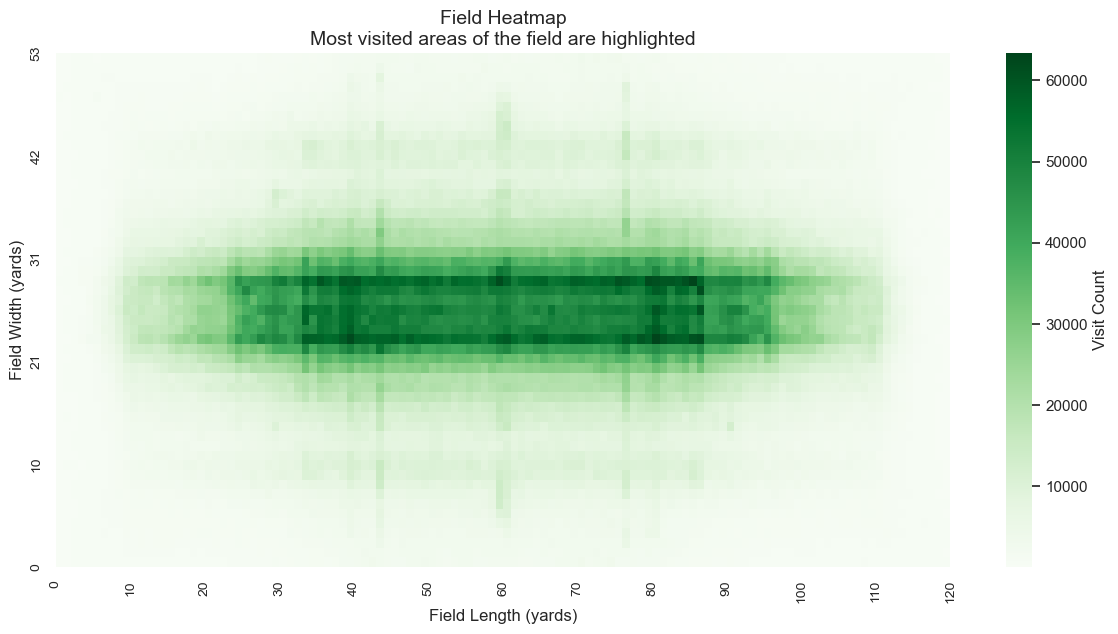

In [59]:
visualize_field_heatmap(player_df) #you can see some areas of the field are more 'busy' than others (presumably the line of srimmage)

In [60]:
# location heatmap by field type
surface_map = play_df[['PlayKey', 'FieldType']]
surface_mape = surface_map.drop_duplicates()
surface_map = surface_map.set_index('PlayKey')['FieldType']

player_df_fieldtype = player_df.copy()
player_df_fieldtype['FieldType'] = player_df_fieldtype['PlayKey'].map(surface_map)
player_df_fieldtype


,PlayKey,time,event,x,y,dir,dis,o,s,FieldType
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13,Synthetic
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12,Synthetic
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12,Synthetic
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10,Synthetic
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09,Synthetic
...,...,...,...,...,...,...,...,...,...,...
76366743,47888-13-55,35.8,NaN,74.97,11.50,195.95,0.13,142.95,1.34,Synthetic
76366744,47888-13-55,35.9,NaN,74.94,11.37,195.01,0.13,142.01,1.33,Synthetic
76366745,47888-13-55,36.0,NaN,74.90,11.24,193.99,0.13,143.36,1.33,Synthetic
76366746,47888-13-55,36.1,NaN,74.87,11.11,194.47,0.13,144.87,1.33,Synthetic


In [61]:
player_df_fieldtype = player_df.copy()
player_df_fieldtype['FieldType'] = player_df_fieldtype['PlayKey'].map(surface_map)
player_df_fieldtype

,PlayKey,time,event,x,y,dir,dis,o,s,FieldType
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13,Synthetic
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12,Synthetic
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12,Synthetic
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10,Synthetic
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09,Synthetic
...,...,...,...,...,...,...,...,...,...,...
76366743,47888-13-55,35.8,NaN,74.97,11.50,195.95,0.13,142.95,1.34,Synthetic
76366744,47888-13-55,35.9,NaN,74.94,11.37,195.01,0.13,142.01,1.33,Synthetic
76366745,47888-13-55,36.0,NaN,74.90,11.24,193.99,0.13,143.36,1.33,Synthetic
76366746,47888-13-55,36.1,NaN,74.87,11.11,194.47,0.13,144.87,1.33,Synthetic


In [62]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_field_heatmap_w_subplots(
    ngs_df,
    xbins=120,
    ybins=53,
    annotate=False,
    cmap="Greens",
    ax=None
):
    """
    Heatmap of the football field (120×53.3 yards) with green turf and white yard lines.
    ngs_df must have 'x' (0–120) and 'y' (0–53.3) in yards.
    If ax is None, creates its own figure/axes; otherwise draws on the provided ax.
    """
    # compute 2D histogram
    heat, y_edges, x_edges = np.histogram2d(
        ngs_df['y'], ngs_df['x'],
        bins=[ybins, xbins],
        range=[[0, 53.3], [0, 120]]
    )

    # if no axes passed, create one
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6.5))
        created_fig = True

    sns.heatmap(
        heat,
        cmap=cmap,
        cbar_kws={'label': 'Visit Count'},
        annot=annotate,
        fmt='.0f',
        ax=ax
    )
    ax.invert_yaxis()

    # white yard lines every 10 yards
    x_ticks = np.linspace(0, xbins, 13)
    y_ticks = np.linspace(0, ybins, 6)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
    ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)
    ax.grid(which='major', color='white', linewidth=1.5)
    ax.grid(which='minor', visible=False)

    ax.set_xlabel('Field Length (yards)', fontsize=12)
    ax.set_ylabel('Field Width (yards)', fontsize=12)

    if created_fig:
        ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
        plt.tight_layout()
        plt.show()

    return ax

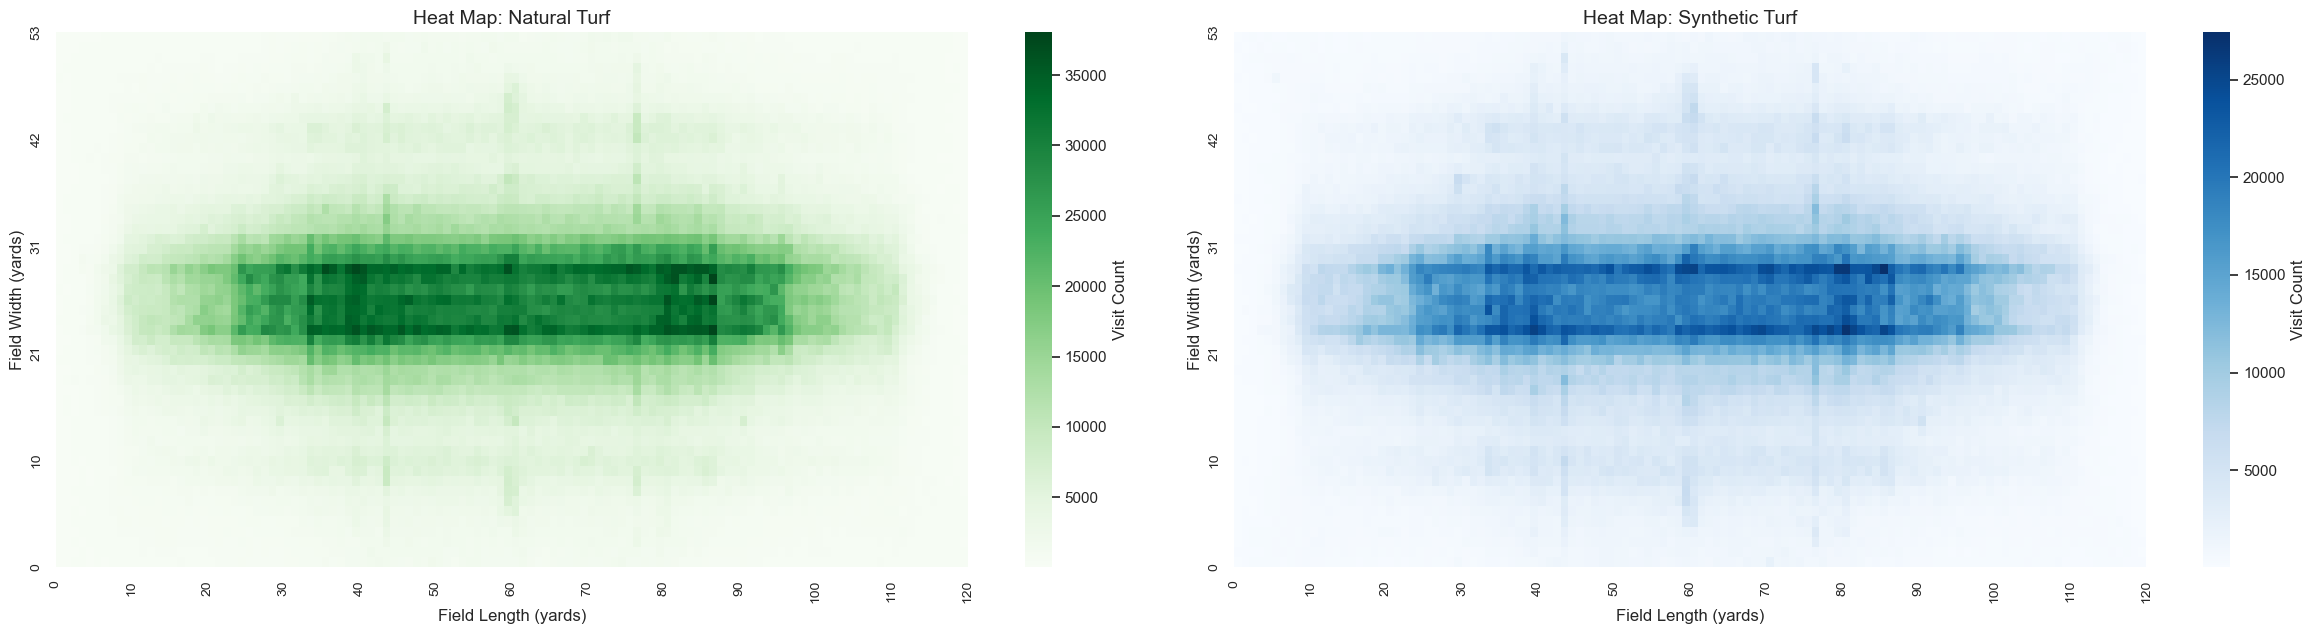

In [63]:
# === USAGE EXAMPLE WITH TWO DATAFRAMES SIDE BY SIDE ===

# assume df1 and df2 are your two NGS dataframes:
fig, axes = plt.subplots(1, 2, figsize=(24, 6.5))

# left heatmap
visualize_field_heatmap_w_subplots(
    ngs_df=player_df_fieldtype.query('FieldType == "Natural"'),
    annotate=False,
    cmap="Greens",
    ax=axes[0]
)
axes[0].set_title("Heat Map: Natural Turf", fontsize=14)

# right heatmap
visualize_field_heatmap_w_subplots(
    ngs_df=player_df_fieldtype.query('FieldType == "Synthetic"'),
    annotate=False,
    cmap="Blues",
    ax=axes[1]
)
axes[1].set_title("Heat Map: Synthetic Turf", fontsize=14)

plt.tight_layout()
plt.show()

In [64]:
play_df

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267000,47888,47888-13,47888-13-51,Cornerback,99,13,Outdoor,Synthetic,33,Sunny and cold,Pass,51,DB,DB
267001,47888,47888-13,47888-13-52,Cornerback,99,13,Outdoor,Synthetic,33,Sunny and cold,Pass,52,DB,DB
267002,47888,47888-13,47888-13-53,Cornerback,99,13,Outdoor,Synthetic,33,Sunny and cold,Pass,53,DB,DB
267003,47888,47888-13,47888-13-54,Cornerback,99,13,Outdoor,Synthetic,33,Sunny and cold,Pass,54,DB,DB


In [66]:
def create_motion_data_df(injury_df, play_df, player_df):
    """
    Create a motion-aggregated dataframe by combining player, play, and injury data.

    Args:
        injury_df (DataFrame): Injury-level dataset.
        play_df (DataFrame): Play-level dataset.
        player_df (DataFrame): Player tracking dataset (includes motion features).

    Returns:
        DataFrame: Merged dataset with motion data aggregated at the play level.
    """
    # --- Create a new field: angle between orientation and direction ---
    player_df['angle'] = player_df['o'] - player_df['dir']

    # --- Group motion features by PlayKey ---
    # Maximum values per play
    grouped_max = (
        player_df[['PlayKey', 'time', 'dir', 'dis', 'o', 's', 'angle']]
        .groupby('PlayKey')
        .max()
    )

    # Average values per play
    grouped_avg = (
        player_df[['PlayKey', 'time', 'dir', 'dis', 'o', 's', 'angle']]
        .groupby('PlayKey')
        .mean()
    )

    # --- Merge aggregated motion features back into play data ---
    play_df = play_df.merge(
        grouped_max.reset_index(),
        on='PlayKey'
    ).merge(
        grouped_avg.reset_index(),
        on='PlayKey',
        suffixes=('_max', '_avg')
    )

    # --- Merge with injury data (dropping unnecessary columns first) ---
    injury_df_cleaned = injury_df.drop(
        columns=['PlayerKey', 'GameID', 'BodyPart', 'Surface']
    )

    merged_df = injury_df_cleaned.merge(
        play_df, on='PlayKey', how='outer'
    ).fillna(0)

    return merged_df


In [67]:
motion_df = create_motion_data_df(injury_df, play_df, player_df)
# Select injury columns automatically
injury_cols = [col for col in motion_df.columns if col.startswith('DM_M')]

# Sum across them to create the Injury flag
motion_df['Injury'] = motion_df[injury_cols].sum(axis=1)
motion_df.head()

,PlayKey,DM_M1,DM_M7,DM_M28,DM_M42,PlayerKey,GameID,RosterPosition,PlayerDay,PlayerGame,...,o_max,s_max,angle_max,time_avg,dir_avg,dis_avg,o_avg,s_avg,angle_avg,Injury
0,26624-1-1,0.0,0.0,0.0,0.0,26624.0,26624-1,Quarterback,1.0,1.0,...,267.03,2.94,265.19,14.90,186.148361,0.056288,182.479766,0.535753,-3.668595,0.0
1,26624-1-10,0.0,0.0,0.0,0.0,26624.0,26624-1,Quarterback,1.0,1.0,...,315.08,3.18,260.69,13.75,199.524167,0.061848,200.858225,0.576304,1.334058,0.0
2,26624-1-11,0.0,0.0,0.0,0.0,26624.0,26624-1,Quarterback,1.0,1.0,...,358.20,2.94,314.68,18.40,201.652520,0.084553,188.591789,0.795772,-13.060732,0.0
3,26624-1-12,0.0,0.0,0.0,0.0,26624.0,26624-1,Quarterback,1.0,1.0,...,302.26,1.83,299.54,17.80,174.236134,0.041176,215.746975,0.349692,41.510840,0.0
4,26624-1-13,0.0,0.0,0.0,0.0,26624.0,26624-1,Quarterback,1.0,1.0,...,356.69,1.49,295.07,12.75,176.954727,0.051797,189.170742,0.427109,12.216016,0.0


In [68]:
only_injuries = pd.merge(player_df, motion_df[['PlayKey', 'Injury', 'FieldType']], left_on='PlayKey', right_on='PlayKey', how='left')
only_injuries = only_injuries.query('Injury == 1')
only_injuries['Injury'].value_counts()

Injury
1.0    4837
Name: count, dtype: int64

In [69]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_field_heatmap_w_subplots(
    ngs_df,
    xbins=120,
    ybins=53,
    annotate=False,
    cmap="Greens",
    ax=None
):
    """
    Heatmap of the football field (120×53.3 yards) with green turf and white yard lines.
    ngs_df must have 'x' (0–120) and 'y' (0–53.3) in yards.
    If ax is None, creates its own figure/axes; otherwise draws on the provided ax.
    """
    # compute 2D histogram
    heat, y_edges, x_edges = np.histogram2d(
        ngs_df['y'], ngs_df['x'],
        bins=[ybins, xbins],
        range=[[0, 53.3], [0, 120]]
    )

    # if no axes passed, create one
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6.5))
        created_fig = True

    sns.heatmap(
        heat,
        cmap=cmap,
        cbar_kws={'label': 'Visit Count'},
        annot=annotate,
        fmt='.0f',
        ax=ax
    )
    ax.invert_yaxis()

    # white yard lines every 10 yards
    x_ticks = np.linspace(0, xbins, 13)
    y_ticks = np.linspace(0, ybins, 6)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
    ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)
    ax.grid(which='major', color='white', linewidth=1.5)
    ax.grid(which='minor', visible=False)

    ax.set_xlabel('Field Length (yards)', fontsize=12)
    ax.set_ylabel('Field Width (yards)', fontsize=12)

    if created_fig:
        ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
        plt.tight_layout()
        plt.show()

    return ax

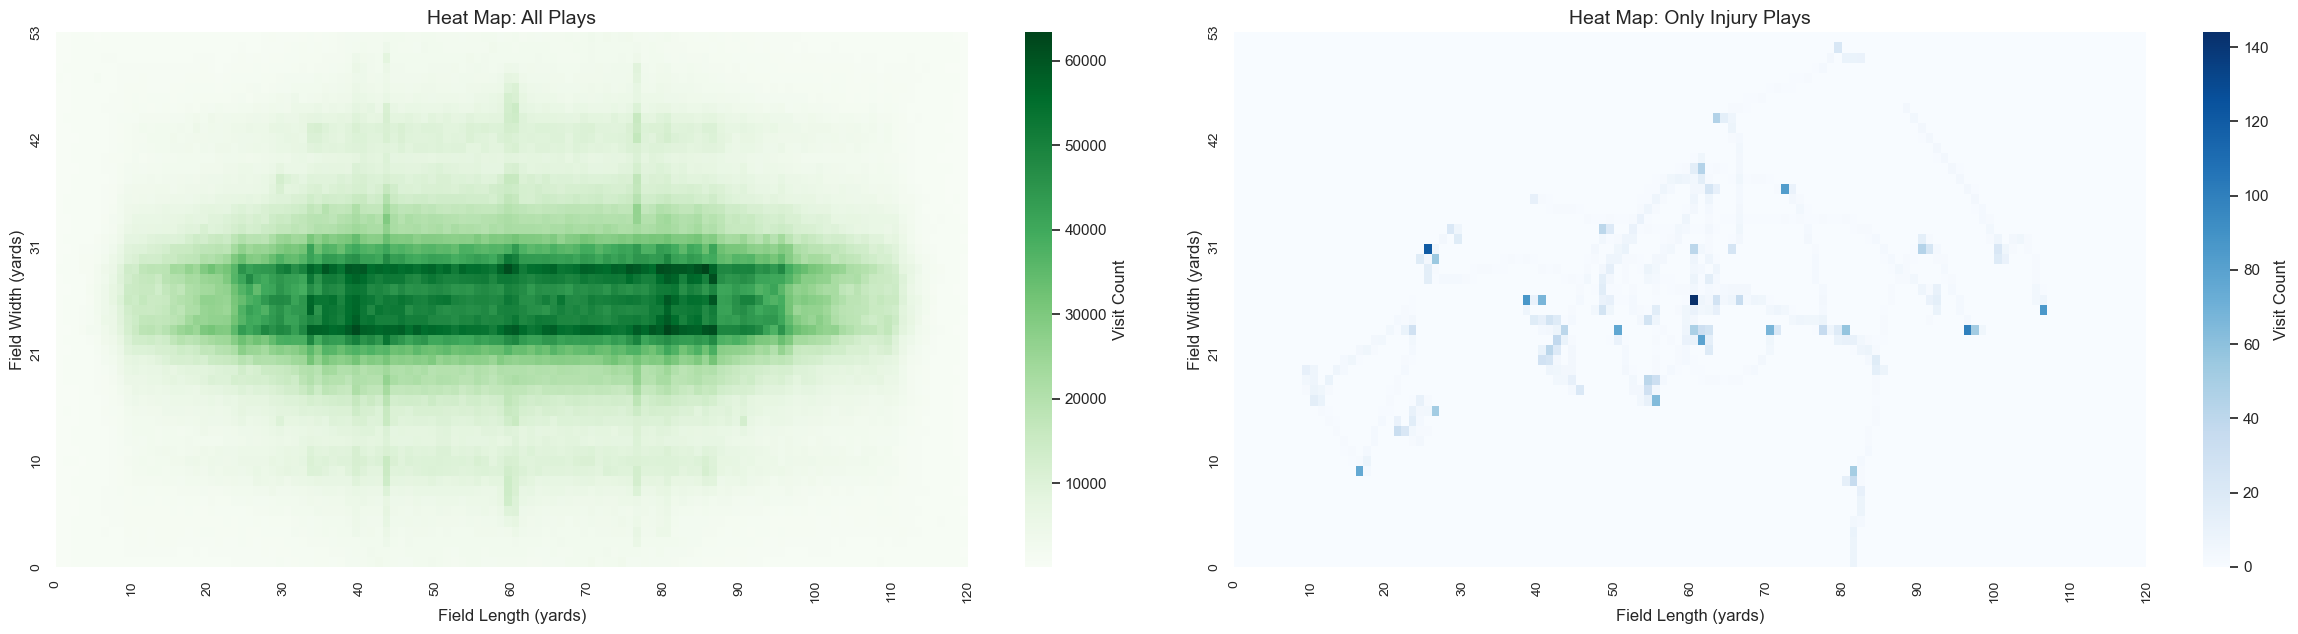

In [70]:
# === USAGE EXAMPLE WITH TWO DATAFRAMES SIDE BY SIDE ===

# assume df1 and df2 are your two NGS dataframes:
fig, axes = plt.subplots(1, 2, figsize=(24, 6.5))

# left heatmap
visualize_field_heatmap_w_subplots(
    ngs_df=player_df,
    annotate=False,
    cmap="Greens",
    ax=axes[0]
)
axes[0].set_title("Heat Map: All Plays", fontsize=14)

# right heatmap
visualize_field_heatmap_w_subplots(
    ngs_df=only_injuries,
    annotate=False,
    cmap="Blues",
    ax=axes[1]
)
axes[1].set_title("Heat Map: Only Injury Plays", fontsize=14)

plt.tight_layout()
plt.show()

In [71]:
injury_df

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1
...,...,...,...,...,...,...,...,...,...
100,44423,44423-13,NaN,Knee,Synthetic,1,0,0,0
101,31933,31933-20,NaN,Knee,Synthetic,1,0,0,0
102,47285,47285-4,NaN,Knee,Natural,1,1,0,0
103,37068,37068-19,NaN,Knee,Natural,1,1,0,0


In [72]:
only_injuries.query('PlayKey == "38192-8-8"')['event'].value_counts()

event
huddle_start_offense    1
huddle_break_offense    1
line_set                1
ball_snap               1
pass_forward            1
pass_arrived            1
pass_outcome_caught     1
first_contact           1
tackle                  1
Name: count, dtype: int64

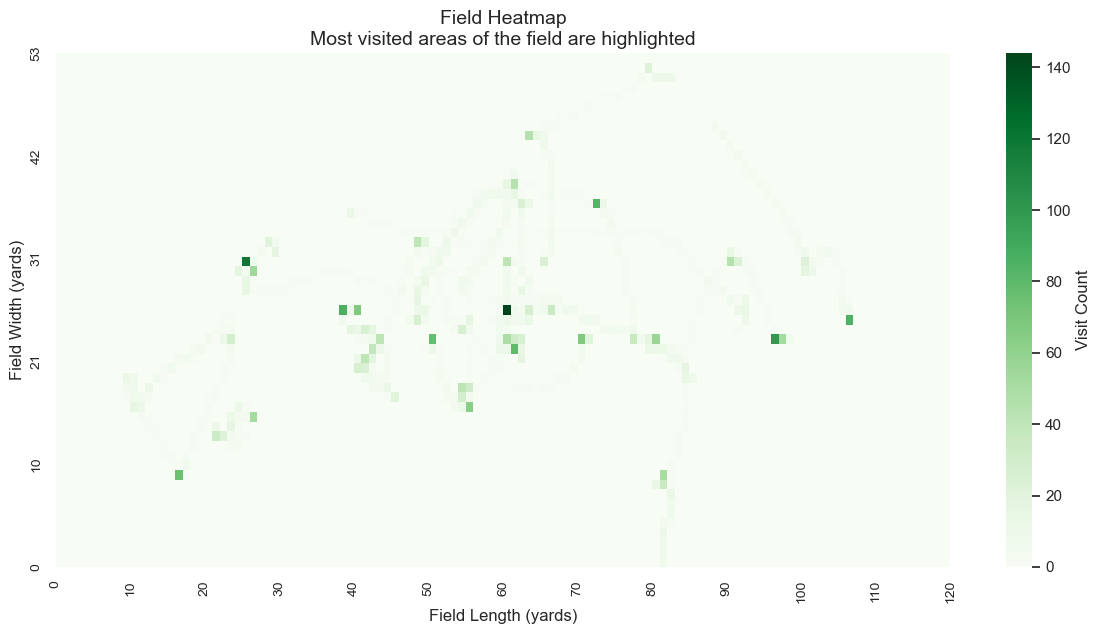

In [73]:
visualize_field_heatmap(only_injuries)

In [74]:
game_injury_df.head()

,BodyPart,DM_M1,DM_M7,DM_M28,DM_M42,StadiumType,FieldType,Weather,Temperature,Injury
GameID,,,,,,,,,,
26624-1,NaN,0,0,0,0,Outdoor,Synthetic,Clear,63,0
26624-10,NaN,0,0,0,0,Outdoor,Natural,Clear,66,0
26624-11,NaN,0,0,0,0,Outdoor,Synthetic,Cloudy,47,0
26624-12,NaN,0,0,0,0,Outdoor,Synthetic,Cloudy,48,0
26624-13,NaN,0,0,0,0,Outdoor,Natural,Clear,55,0


In [75]:
motion_df

,PlayKey,DM_M1,DM_M7,DM_M28,DM_M42,PlayerKey,GameID,RosterPosition,PlayerDay,PlayerGame,...,o_max,s_max,angle_max,time_avg,dir_avg,dis_avg,o_avg,s_avg,angle_avg,Injury
0,26624-1-1,0.0,0.0,0.0,0.0,26624.0,26624-1,Quarterback,1.0,1.0,...,267.03,2.94,265.19,14.90,186.148361,0.056288,182.479766,0.535753,-3.668595,0.0
1,26624-1-10,0.0,0.0,0.0,0.0,26624.0,26624-1,Quarterback,1.0,1.0,...,315.08,3.18,260.69,13.75,199.524167,0.061848,200.858225,0.576304,1.334058,0.0
2,26624-1-11,0.0,0.0,0.0,0.0,26624.0,26624-1,Quarterback,1.0,1.0,...,358.20,2.94,314.68,18.40,201.652520,0.084553,188.591789,0.795772,-13.060732,0.0
3,26624-1-12,0.0,0.0,0.0,0.0,26624.0,26624-1,Quarterback,1.0,1.0,...,302.26,1.83,299.54,17.80,174.236134,0.041176,215.746975,0.349692,41.510840,0.0
4,26624-1-13,0.0,0.0,0.0,0.0,26624.0,26624-1,Quarterback,1.0,1.0,...,356.69,1.49,295.07,12.75,176.954727,0.051797,189.170742,0.427109,12.216016,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266984,0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
266985,0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
266986,0,1.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
266987,0,1.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,2.0


In [76]:
# Prepare the features (drop leakage columns)
X = motion_df.drop(columns=[
    'Injury', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'PlayKey', 'PlayerKey', 'GameID'
])

# One-hot encode categorical columns
X = pd.get_dummies(X, dummy_na=True, drop_first=True, dtype='int')

# Convert 1-hot to binary labels:
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype('int32')


# 3. Prepare the binary target (0 = no injury, 1 = injury)
y = motion_df['Injury'].copy()
y_binary = y.copy()
y_binary[y_binary > 0] = 1

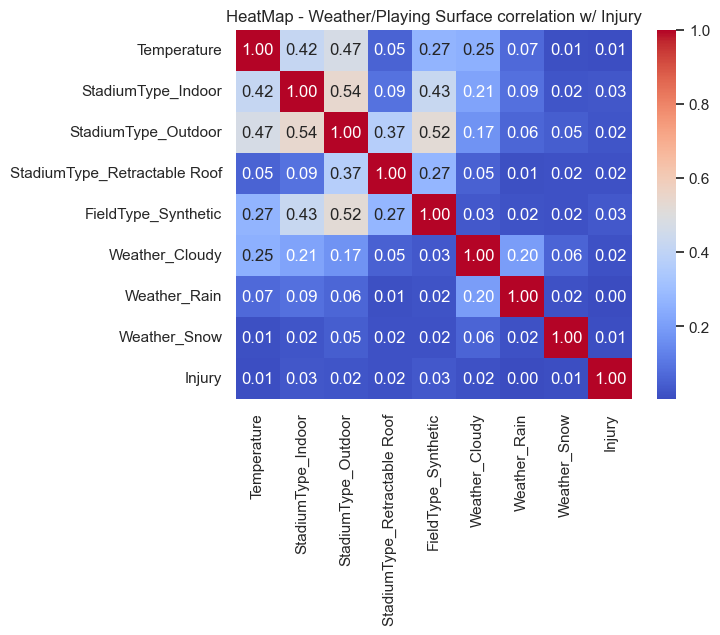

In [77]:
# Correlation matrix
corr_df = game_injury_df_dummies[['Temperature', 'StadiumType_Indoor', 
                                  'StadiumType_Outdoor', 'StadiumType_Retractable Roof',
                                  'FieldType_Synthetic', 'Weather_Cloudy', 
                                  'Weather_Rain', 'Weather_Snow', 
                                  'Injury']]
corr_df = corr_df.corr().abs()

sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=corr_df.columns, yticklabels=corr_df.columns)
plt.title('HeatMap - Weather/Playing Surface correlation w/ Injury')
plt.show()


In [78]:
# --- Join cleaned play dataset with injury dataset on PlayKey ---
play_injury_df = (
    injury_df.dropna(subset=['PlayKey'])
    .set_index('PlayKey')
    .join(
        play_df_cleaned.set_index('PlayKey'), 
        how='outer', 
        lsuffix='_left', 
        rsuffix='_right'
    )
)

# --- Fill missing injury columns with zeros and convert to integer ---
for col in ['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']:
    play_injury_df[col] = play_injury_df[col].fillna(0).astype(int)

# --- Adjust injury metrics by subtracting later windows ---
play_injury_df['DM_M1']  = play_injury_df['DM_M1']  - play_injury_df['DM_M7']
play_injury_df['DM_M7']  = play_injury_df['DM_M7']  - play_injury_df['DM_M28']
play_injury_df['DM_M28'] = play_injury_df['DM_M28'] - play_injury_df['DM_M42']

# --- Introduce an 'Injury' flag indicating any injury occurrence ---
play_injury_df['Injury'] = (
    play_injury_df['DM_M1'] +
    play_injury_df['DM_M7'] +
    play_injury_df['DM_M28'] +
    play_injury_df['DM_M42']
)

# --- Drop duplicated surface column (already exists elsewhere) ---
play_injury_df = play_injury_df.drop(columns=['Surface']).copy()

# --- Create dummy variables for PlayType and PositionGroup ---
play_injury_df_dummies = pd.get_dummies(
    play_injury_df,
    columns=['PlayType', 'PositionGroup'],
    dummy_na=True,
    drop_first=True
)


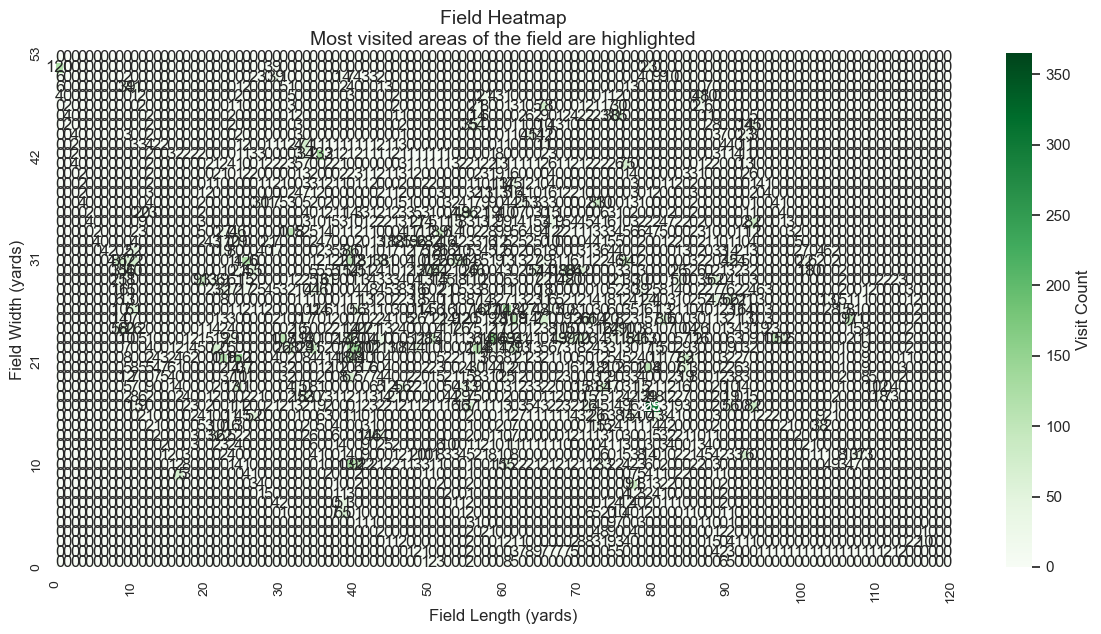

In [79]:
# find the keys of the plays related to injuries
play_injuries = play_injury_df.reset_index().dropna()[['PlayKey']]

# merge the playkeys associated with injuries with players' positions
player_injuries = player_df.merge(play_injuries, on='PlayKey', how = 'inner') # use inner join!

# visualize the heatmap
visualize_field_heatmap( player_injuries, annotate = True )

In [80]:
def visualize_field_kde(player_df):
    # plot kde
    fig = plt.figure(figsize=(10,5))
    ax = sns.jointplot(x="x", y="y", data=player_df, kind="kde")
    plt.show()

<Figure size 1000x500 with 0 Axes>

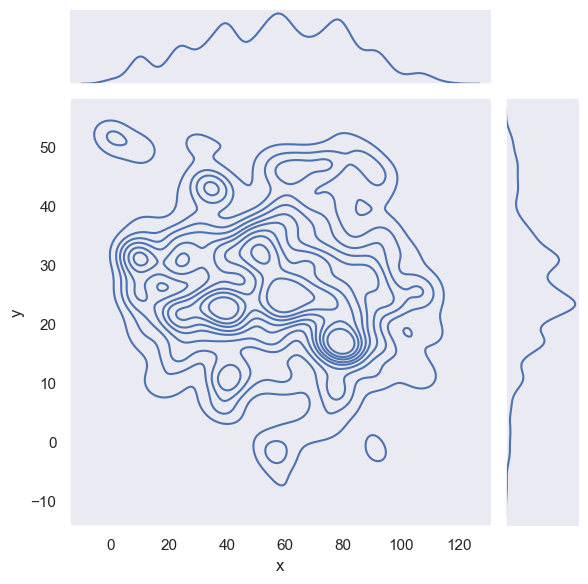

In [81]:
visualize_field_kde(player_injuries)

In [82]:
# reset index 
features_df = play_injury_df.copy().reset_index()
# drop the irrelevant columns
features_df = features_df.drop(columns=['PlayerKey_left','GameID_left','BodyPart', 'PlayKey', 'PlayerKey_right', 'GameID_right','DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])
# convert into dummies
features_df = pd.get_dummies(features_df, dummy_na = False, drop_first = True)
features_df

,PlayerDay,PlayerGame,Temperature,PlayerGamePlay,Injury,RosterPosition_Defensive Lineman,RosterPosition_Kicker,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,RosterPosition_Quarterback,...,Position_WR,PositionGroup_DL,PositionGroup_LB,PositionGroup_Missing Data,PositionGroup_OL,PositionGroup_QB,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR
0,1,1,63,1,0,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,1,1,63,10,0,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
2,1,1,63,11,0,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
3,1,1,63,12,0,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
4,1,1,63,13,0,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267001,71,9,53,54,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
267002,71,9,53,6,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
267003,71,9,53,7,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
267004,71,9,53,8,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


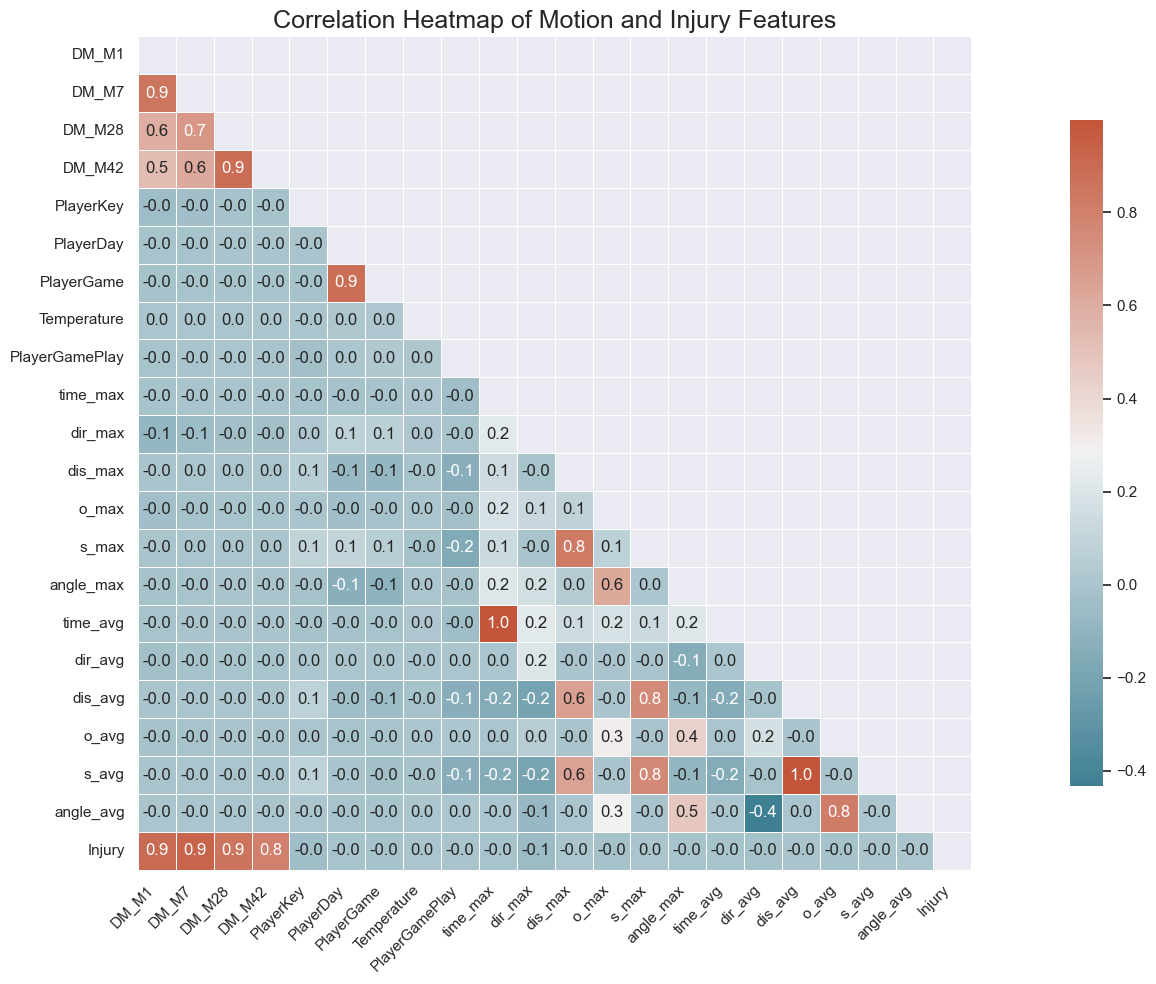

In [84]:
# --- Select only numeric columns and compute correlation matrix ---
corr_df = motion_df.select_dtypes(include=['number']).corr()

# --- Create a mask for the upper triangle ---
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# --- Plot the masked heatmap ---
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    corr_df,
    mask=mask,                         # <-- mask the upper triangle
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    annot=True,
    fmt='.1f',
    square=True,
    linewidths=0.5,                     # <-- adds clean grid lines
    cbar_kws={"shrink": 0.8},           # <-- shrink colorbar a bit
    ax=ax,
    xticklabels=corr_df.columns, 
    yticklabels=corr_df.columns
)

ax.set_title('Correlation Heatmap of Motion and Injury Features', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [85]:
# create a copy for the rest of our analysis
motion_df_cleaned = motion_df.copy()
motion_df_cleaned['s_max'] = pd.to_numeric(motion_df_cleaned['s_max'], errors='coerce')
print(motion_df_cleaned['s_max'].dtype) # check the type of the column

float64


In [86]:
#drop id columns
motion_df_cleaned = motion_df_cleaned.drop(columns=['PlayKey', 'GameID', 'PlayerKey'])

#one-hot encode categorical variables
motion_df_encoded = pd.get_dummies(
    motion_df_cleaned,
    columns=['RosterPosition', 'StadiumType', 'FieldType', 'Weather', 'PlayType', 'Position', 'PositionGroup'],
    dummy_na=True,
    drop_first=True
)

motion_df_encoded.head()

,DM_M1,DM_M7,DM_M28,DM_M42,PlayerDay,PlayerGame,Temperature,PlayerGamePlay,time_max,dir_max,...,PositionGroup_DB,PositionGroup_DL,PositionGroup_LB,PositionGroup_OL,PositionGroup_QB,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR,PositionGroup_nan
0,0.0,0.0,0.0,0.0,1.0,1.0,63.0,1.0,29.8,337.87,...,False,False,False,False,True,False,False,False,False,False
1,0.0,0.0,0.0,0.0,1.0,1.0,63.0,10.0,27.5,353.24,...,False,False,False,False,True,False,False,False,False,False
2,0.0,0.0,0.0,0.0,1.0,1.0,63.0,11.0,36.8,357.78,...,False,False,False,False,True,False,False,False,False,False
3,0.0,0.0,0.0,0.0,1.0,1.0,63.0,12.0,35.6,359.97,...,False,False,False,False,True,False,False,False,False,False
4,0.0,0.0,0.0,0.0,1.0,1.0,63.0,13.0,25.5,357.43,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
motion_df_encoded.to_csv('datasets/nfl-playing-surface-analytics/motion_df_encoded.csv', index=False)

In [87]:
print(motion_df_encoded.columns)

Index(['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'PlayerDay', 'PlayerGame',
       'Temperature', 'PlayerGamePlay', 'time_max', 'dir_max',
       ...
       'PositionGroup_DB', 'PositionGroup_DL', 'PositionGroup_LB',
       'PositionGroup_OL', 'PositionGroup_QB', 'PositionGroup_RB',
       'PositionGroup_SPEC', 'PositionGroup_TE', 'PositionGroup_WR',
       'PositionGroup_nan'],
      dtype='object', length=174)


### Draw bubble plots.

In [88]:
# Drop rows in motion_df where FieldType is 0
motion_df_2 = motion_df[motion_df['FieldType'] != 0].copy()
motion_df_2.reset_index(drop=True, inplace=True)

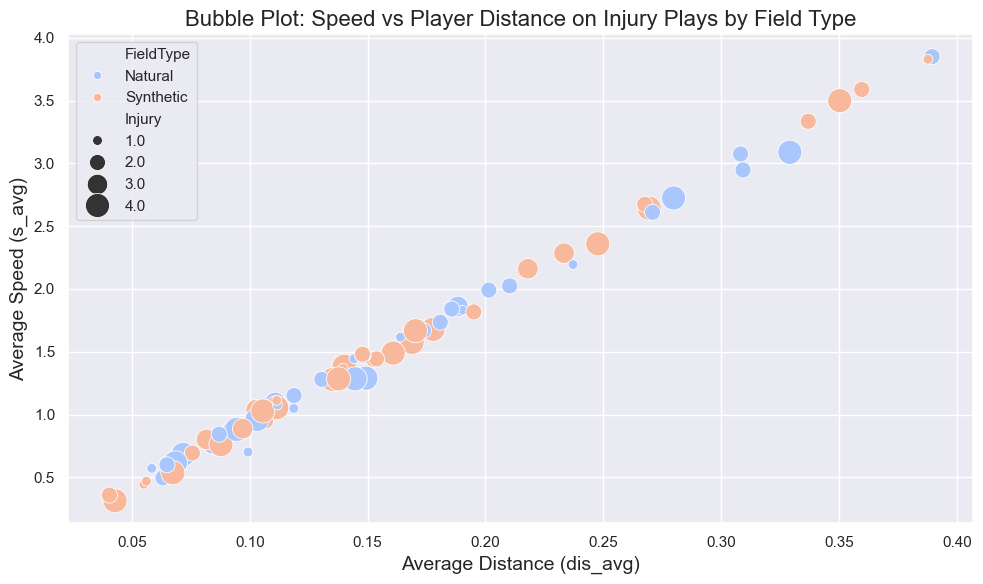

In [93]:
# Set a nicer theme
sns.set_theme(style='dark')

# Create a bubble plot
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=motion_df_2[motion_df_2['Injury'] > 0],  # only injured plays
    x='dis_avg',
    y='s_avg',
    size='Injury',
    hue='FieldType',
    palette='coolwarm',
    sizes=(50, 300),
    edgecolor='w'
)


plt.title('Bubble Plot: Speed vs Player Distance on Injury Plays by Field Type', fontsize=16)
plt.xlabel('Average Distance (dis_avg)', fontsize=14)
plt.ylabel('Average Speed (s_avg)', fontsize=14)
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


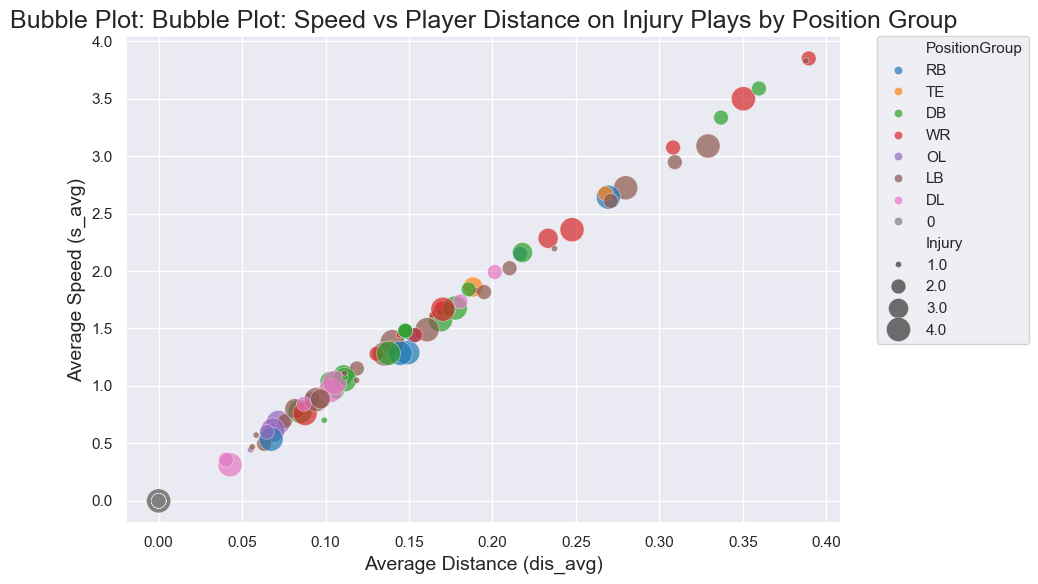

In [98]:
sns.set_theme(style='dark')


# Make sure PositionGroup is clean
motion_df['PositionGroup'] = motion_df['PositionGroup'].fillna('Unknown')

# Create the bubble plot
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=motion_df[motion_df['Injury'] > 0],  # only injured plays,
    x='dis_avg',               # x-axis: average distance
    y='s_avg',                 # y-axis: average speed
    size='Injury',             # bubble size based on Injury
    hue='PositionGroup',       # bubble color based on PositionGroup
    palette='tab10',           # 10-class categorical color map
    sizes=(20, 300),           # smaller size range
    alpha=0.7,
    edgecolor='w'
)

plt.title('Bubble Plot: Bubble Plot: Speed vs Player Distance on Injury Plays by Position Group', fontsize=18)
plt.xlabel('Average Distance (dis_avg)', fontsize=14)
plt.ylabel('Average Speed (s_avg)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.grid(True)
plt.tight_layout()
plt.show()


### Principal Component Analysis - Perform Principal Component Analysis to find out the directions in which the data varies.



### Can your Represent the data using only its projection onto the first principal component, using the methods described in week 8, How much of the variance would this capture?

PS Note - Ths target variable of this data set ("Injury") is an incredibly poor fit for linear regression. we'll build a different subset of the data and test something that is a better fit for that algorithm - I'm gonna go with 'max_speed', given player position and the other motion data - should be easier to follow and work with 

In [99]:
player_df.head()

,PlayKey,time,event,x,y,dir,dis,o,s,angle
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13,-25.91
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12,-22.22
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12,-19.23
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10,-18.13
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09,-15.17


In [100]:
game_df.head()

,GameID,StadiumType,FieldType,Weather,Temperature
0,26624-1,Outdoor,Synthetic,Clear and warm,63
1,26624-2,Indoors,Synthetic,Mostly Cloudy,85
2,26624-3,Outdoor,Synthetic,Sunny,84
3,26624-4,Outdoor,Synthetic,Sunny,61
4,26624-5,Outdoor,Natural,Clear,76


In [ ]:
play_df

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267000,47888,47888-13,47888-13-51,Cornerback,99,13,Outdoor,Synthetic,33,Sunny and cold,Pass,51,DB,DB
267001,47888,47888-13,47888-13-52,Cornerback,99,13,Outdoor,Synthetic,33,Sunny and cold,Pass,52,DB,DB
267002,47888,47888-13,47888-13-53,Cornerback,99,13,Outdoor,Synthetic,33,Sunny and cold,Pass,53,DB,DB
267003,47888,47888-13,47888-13-54,Cornerback,99,13,Outdoor,Synthetic,33,Sunny and cold,Pass,54,DB,DB


In [ ]:
# set up our new dataset
player_df_grouped = player_df.groupby('PlayKey').agg({
    's': ['mean', 'max', 'std'],
    'x': ['min', 'max', 'mean'],
    'y': ['min', 'max', 'mean']
})

player_df_grouped = player_df_grouped.reset_index()
player_df_grouped.columns = ['PlayKey', 's_mean', 's_max', 's_std', 'x_min', 'x_max', 'x_mean', 'y_min', 'y_max', 'y_mean']
player_df_grouped = player_df_grouped.merge(play_df[['PlayKey', 'RosterPosition', 'FieldType', 'PlayType']], left_on='PlayKey', right_on='PlayKey', how='left')


In [ ]:
# pick out target and features
X = player_df_grouped.drop(columns=['PlayKey', 's_max'])
y = player_df_grouped['s_max']
X = pd.get_dummies(X, columns=['RosterPosition', 'FieldType', 'PlayType'], drop_first=True)
X.head()

,s_mean,s_std,x_min,x_max,x_mean,y_min,y_max,y_mean,RosterPosition_Defensive Lineman,RosterPosition_Kicker,...,PlayType_Extra Point,PlayType_Field Goal,PlayType_Kickoff,PlayType_Kickoff Not Returned,PlayType_Kickoff Returned,PlayType_Pass,PlayType_Punt,PlayType_Punt Not Returned,PlayType_Punt Returned,PlayType_Rush
0,0.535753,0.608942,84.36,91.49,87.665753,23.62,29.85,28.221104,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.576304,0.642887,13.39,18.56,15.893188,22.07,27.49,24.006486,False,False,...,False,False,False,False,False,True,False,False,False,False
2,0.795772,0.738191,7.16,19.65,13.429593,22.56,28.18,24.698211,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0.349692,0.428258,45.55,49.93,46.824706,20.87,24.66,22.817115,False,False,...,False,False,False,False,False,True,False,False,False,False
4,0.427109,0.404819,45.20,49.21,47.015586,21.53,23.97,22.936367,False,False,...,False,False,False,False,False,True,False,False,False,False


In [ ]:
# prep data for PCA
bool_cols = X.select_dtypes(include=['bool']).columns
# Convert boolean columns to integers
X[bool_cols] = X[bool_cols].astype(int)
X.head()

,s_mean,s_std,x_min,x_max,x_mean,y_min,y_max,y_mean,RosterPosition_Defensive Lineman,RosterPosition_Kicker,...,PlayType_Extra Point,PlayType_Field Goal,PlayType_Kickoff,PlayType_Kickoff Not Returned,PlayType_Kickoff Returned,PlayType_Pass,PlayType_Punt,PlayType_Punt Not Returned,PlayType_Punt Returned,PlayType_Rush
0,0.535753,0.608942,84.36,91.49,87.665753,23.62,29.85,28.221104,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.576304,0.642887,13.39,18.56,15.893188,22.07,27.49,24.006486,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.795772,0.738191,7.16,19.65,13.429593,22.56,28.18,24.698211,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.349692,0.428258,45.55,49.93,46.824706,20.87,24.66,22.817115,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.427109,0.404819,45.20,49.21,47.015586,21.53,23.97,22.936367,0,0,...,0,0,0,0,0,1,0,0,0,0


In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
# make a copy for linear regression comparison
X_pca = X.copy()
#scale the data
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Fit PCA
pca = PCA(n_components=20)
pca.fit(X_pca_scaled)

# get first principal component
PC1 = pca.components_[0]
PC2 = pca.components_[1]


# Project data onto PC1
projections = X_pca_scaled @ PC1  # or np.dot(X_scaled, PC1)

# 5. Reconstruct the data using only PC1
X__pca_reconstructed = np.outer(projections, PC1)

# 6. How much variance is captured?
variance_pc1 = pca.explained_variance_ratio_[0]
variance_pc2 = pca.explained_variance_ratio_[1]
print(f"Variance captured by PC1: {variance_pc1:.4f} ({variance_pc1 * 100:.2f}%)")
print(f"Variance captured by PC2: {variance_pc2:.4f} ({variance_pc2 * 100:.2f}%)")

Variance captured by PC1: 0.0337 (3.37%)
Variance captured by PC2: 0.0228 (2.28%)


In [ ]:
pca.explained_variance_ratio_

array([0.10493755, 0.10194518, 0.08509018, 0.06287229, 0.04748391,
       0.043243  , 0.04147734, 0.04079437, 0.03905741, 0.03825092,
       0.03762705, 0.03647499, 0.03641336, 0.03634441, 0.0361153 ,
       0.035936  , 0.03569863, 0.03396354, 0.0323045 , 0.03091217])

No, representing the data using only its projection onto the first principal component is not sufficient. The first principal component only captures 10.5% of the total variance, meaning that significant information would be lost.

### Try performing linear regression analysis using different sets of features.  Which features seem most likely to be useful to predict other features?

*Note - this dataset is not a good fit for linear regression*, see above note

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2 score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R^2 score: 0.8978
Mean Squared Error: 0.4207


In [ ]:
# Get feature importances (coefficients)
feature_importance = model.coef_

# Match back to feature names
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values(by='importance', key=abs, ascending=False)

print(importance_df)

                             feature  importance
1                              s_std    2.615372
18              PlayType_Extra Point   -1.172761
19               PlayType_Field Goal   -1.062474
21     PlayType_Kickoff Not Returned   -0.929035
24                     PlayType_Punt   -0.768799
26            PlayType_Punt Returned   -0.751246
25        PlayType_Punt Not Returned   -0.734006
11  RosterPosition_Offensive Lineman   -0.719164
22         PlayType_Kickoff Returned   -0.590878
20                  PlayType_Kickoff   -0.552026
12        RosterPosition_Quarterback   -0.492080
27                     PlayType_Rush   -0.480194
8   RosterPosition_Defensive Lineman   -0.448526
23                     PlayType_Pass   -0.339044
15          RosterPosition_Tight End   -0.293964
16      RosterPosition_Wide Receiver   -0.214733
0                             s_mean   -0.190728
13       RosterPosition_Running Back   -0.183235
10         RosterPosition_Linebacker   -0.144411
14             Roste

In [ ]:
# Week 8-style feature correlation/comparison
columns = X.columns
results = []

for i, col_target in enumerate(columns):
    best_score = -np.inf
    best_predictor = None
    
    # Loop through all other columns as predictors
    for col_predictor in columns:
        if col_target == col_predictor:
            continue  # don't predict a feature from itself
        
        # Predictor column must be reshaped into 2D
        X_single = X[[col_predictor]]  # make it a dataframe, not a series
        y_single = X[col_target]
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X_single, y_single)
        
        preds = model.predict(X_single)
        
        # Compute R^2 score (or you could use correlation coefficient if you want)
        score = r2_score(y_single, preds)
        
        if score > best_score:
            best_score = score
            best_predictor = col_predictor
    
    # Save the best predictor for this target feature
    results.append({
        'Target Feature': col_target,
        'Best Predictor': best_predictor,
        'Best R^2 Score': best_score
    })

# Compile results into a dataframe
summary_df = pd.DataFrame(results)
print(summary_df)


                      Target Feature                    Best Predictor  \
0                             s_mean                             s_std   
1                              s_std                            s_mean   
2                              x_min                            x_mean   
3                              x_max                            x_mean   
4                             x_mean                             x_max   
5                              y_min                            y_mean   
6                              y_max                            y_mean   
7                             y_mean                             y_min   
8   RosterPosition_Defensive Lineman                            s_mean   
9              RosterPosition_Kicker              PlayType_Extra Point   
10         RosterPosition_Linebacker  RosterPosition_Offensive Lineman   
11  RosterPosition_Offensive Lineman                            s_mean   
12        RosterPosition_Quarterback  

Our results are actually pretty good here, but maybe a little misleading as we haven't dropped the s_std from our dataset yet. 

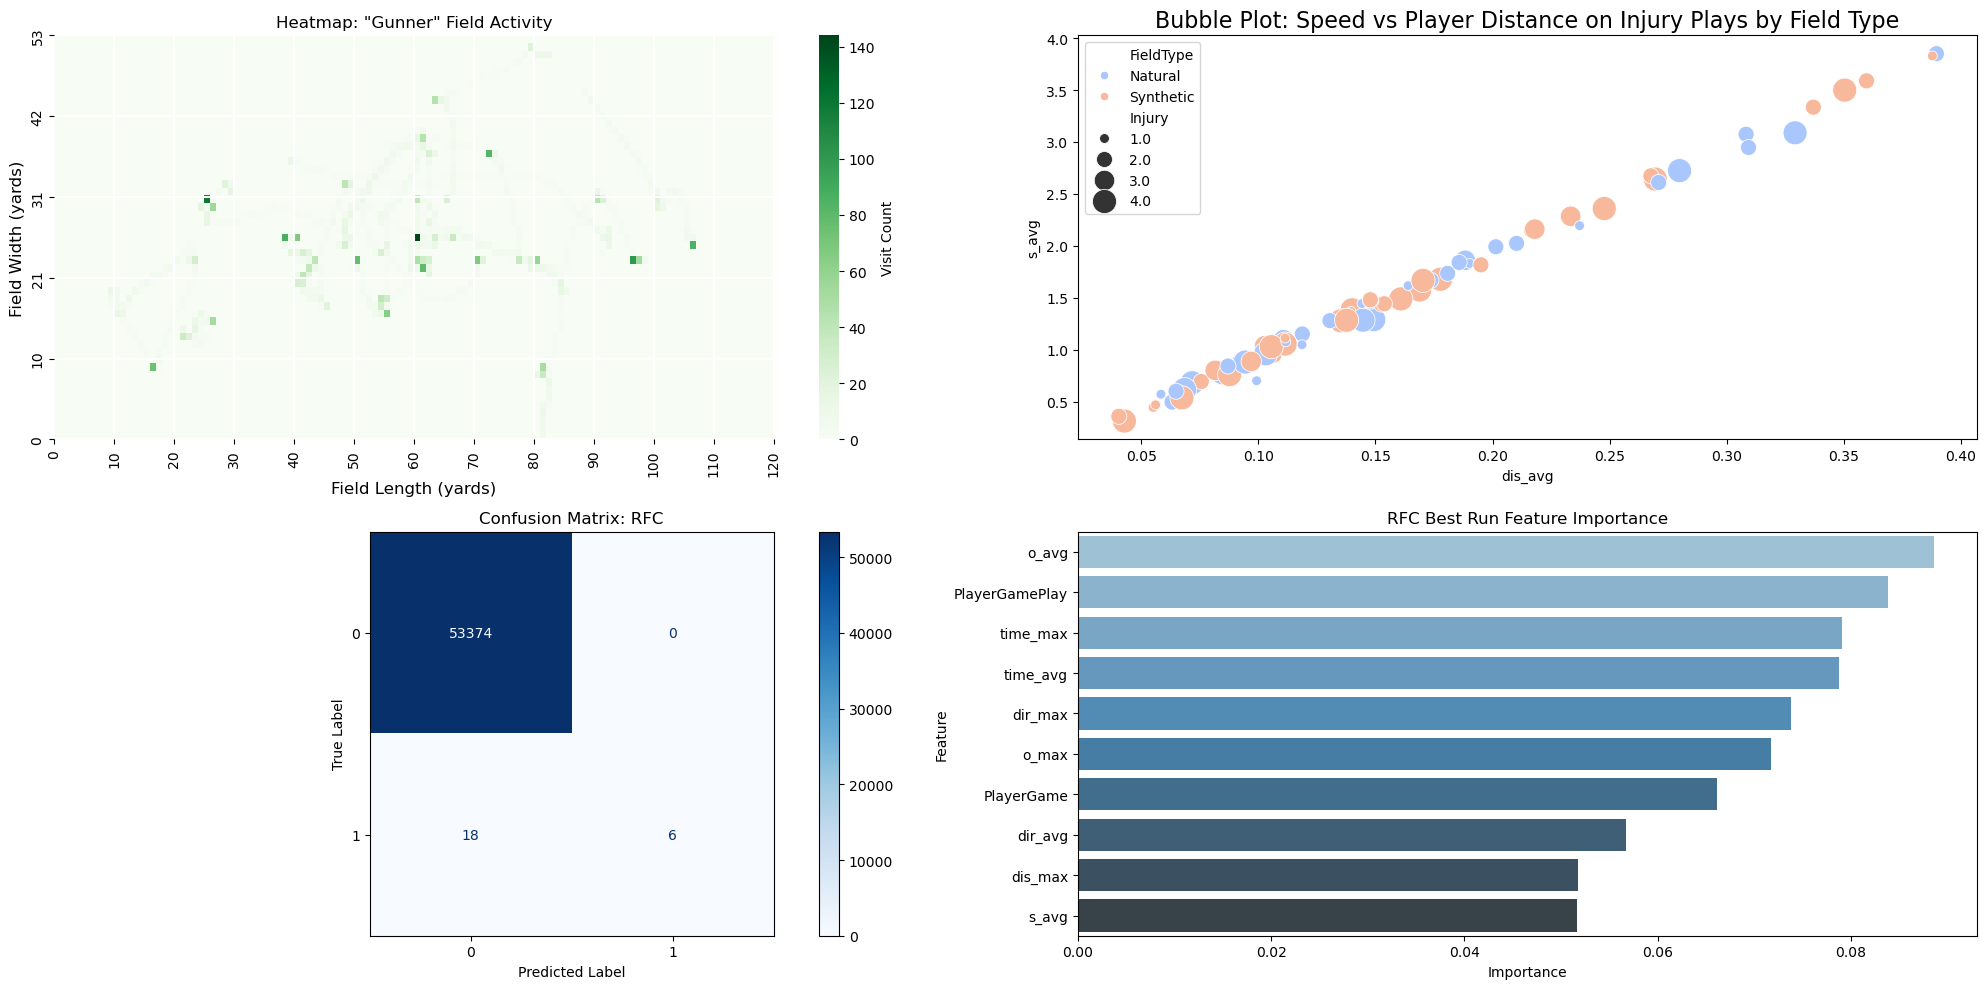

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set up the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# 1. Field heatmap
visualize_field_heatmap_w_subplots(
    ngs_df=only_injuries,
    xbins=120,
    ybins=53,
    annotate=False,
    cmap="Greens",
    ax=axes[0, 0]
)
axes[0, 0].set_title('Heatmap: "Gunner" Field Activity')

# 2. Bubble plot
sns.reset_orig()
sns.scatterplot(
    data=motion_df_2[motion_df_2['Injury'] > 0],  # only injured plays
    x='dis_avg',
    y='s_avg',
    size='Injury',
    hue='FieldType',
    palette='coolwarm',
    sizes=(50, 300),
    edgecolor='w',
    ax = axes[0,1],
    
)

axes[0,1].set_title('Bubble Plot: Speed vs Player Distance on Injury Plays by Field Type', fontsize=16)

# 3. Confusion matrix
def plot_confusion_matrix_subplot(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    # Clear existing subplot so the ConfusionMatrixDisplay renders cleanly
    ax.clear()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=True)

    # Reset the title and axis labels after plotting (disp.plot will overwrite them)
    ax.set_title(title)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plot_confusion_matrix_subplot(axes[1, 0], y_test, y_pred, "Confusion Matrix: RFC")


# 4. Feature importance (horizontal barplot)
data = top10.sort_values(ascending=False)
sns.barplot(
    x=data.values,
    y=data.index,
    ax=axes[1, 1],
    palette="Blues_d"
)
axes[1, 1].set_title("RFC Best Run Feature Importance")
axes[1, 1].set_xlabel("Importance")
axes[1, 1].set_ylabel("Feature")



# Final layout tweaks
plt.tight_layout()
plt.show()

In [102]:
# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report
)

# preprocess data
motion_df = pd.read_csv("datasets/nfl-playing-surface-analytics/motion_df_encoded.csv")

# Prepare the features (drop leakage columns)
X = motion_df.drop(columns=[
    'Injury', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])

# One-hot encode categorical columns
X = pd.get_dummies(X, dummy_na=True, drop_first=True)

# For a cuDF DataFrame with some boolean columns:
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype('int32')


# Prepare the binary target (0 = no injury, 1 = injury)
y = motion_df['Injury'].copy()
y_binary = y.copy()
y_binary[y_binary > 0] = 1

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_binary, 
    test_size=0.2,
    random_state=42,
    shuffle=True       
)

# Initialize and train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

Test Accuracy: 0.9996629087231732


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     53374
         1.0       1.00      0.25      0.40        24

    accuracy                           1.00     53398
   macro avg       1.00      0.62      0.70     53398
weighted avg       1.00      1.00      1.00     53398



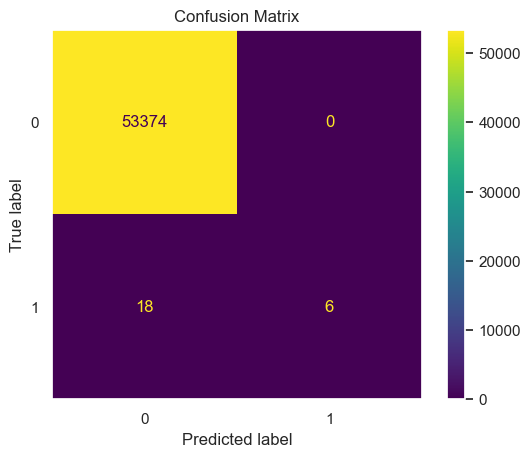

In [103]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# 8. Predict and evaluate
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show() # great accuracy but very poor recal

o_avg             0.088644
PlayerGamePlay    0.083856
time_max          0.079040
time_avg          0.078803
dir_max           0.073747
o_max             0.071678
PlayerGame        0.066108
dir_avg           0.056763
dis_max           0.051796
s_avg             0.051626
dtype: float64


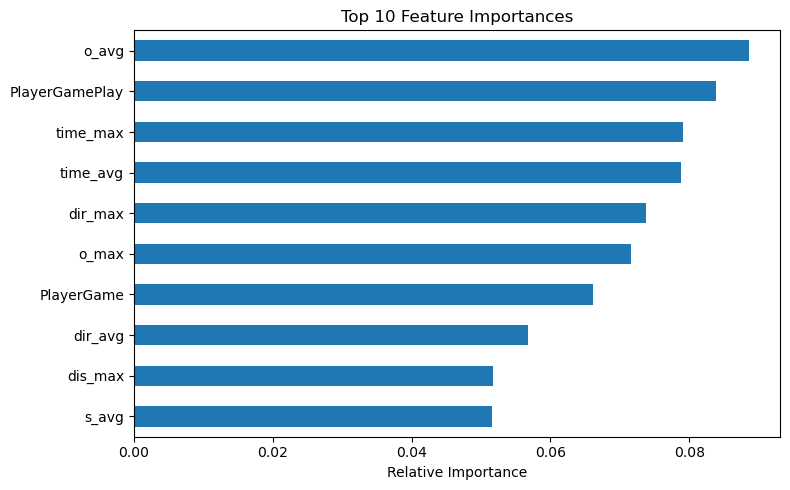

In [109]:
# 1. After rf.fit(X_train, y_train):
importances = rf.feature_importances_

# 2. Turn into a Series for easy sorting & plotting
feat_imp = pd.Series(importances, index=X_train.columns)

# 3. Sort descending and view the top 10
top10 = feat_imp.sort_values(ascending=False).head(10)
print(top10)

# 4. (Optional) Plot as a horizontal bar chart
plt.figure(figsize=(8,5))
top10.sort_values().plot.barh()
plt.title("Top 10 Feature Importances")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

In [ ]:
motion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266989 entries, 0 to 266988
Columns: 174 entries, DM_M1 to PositionGroup_nan
dtypes: bool(153), float64(21)
memory usage: 81.7 MB
